In [1]:
import numpy as np
np.random.seed(1001)

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

import librosa

from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

import os

import wave

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


## Mel Frequency Cepstral Coefficients

In [2]:

COMPLETE_RUN = False


In [6]:

SAMPLE_RATE = 44100
fname = '../../Data/kicks/WRLD-Kick-3-G.wav'   
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
#wav = wav[:2*44100]


In [7]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

(40, 74)

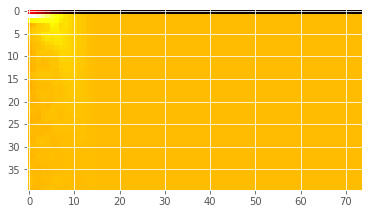

In [8]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

Using TensorFlow backend.


In [7]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [13]:

class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X


In [8]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [9]:


def prepare_data_X(config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        print(fname)
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

def prepare_data_info(data_dir):
    label_list = os.listdir(data_dir)
    if '.DS_Store' in label_list:
        label_list.remove('.DS_Store')
    dataset = { 'filename': [], 'label': [], 'location': [] }
    X = []
    
    for label in label_list:
        
        label_path = os.path.join(data_dir, label)
        file_list = os.listdir(label_path)
        if '.DS_Store' in file_list:
            file_list.remove('.DS_Store')
        
        for file in file_list:
            file_path = os.path.join(label_path, file)
            dataset['filename'].append(file)
            dataset['location'].append(file_path)
            dataset['label'].append(label)
            #data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type='kaiser_fast')
            #data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
            #data = np.expand_dims(data, axis=1)
            #X.append(data)

    return pd.DataFrame(dataset)


dataframe = prepare_data_info('../../Data/drum')


In [16]:

def prepare_data(config, dataset):
    X = np.empty(shape=(dataset.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    
    for i, _ in enumerate(dataset.index):
        file_path = dataset['location'][i]
        
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

data = prepare_data(config, dataframe)

In [20]:

test = pd.read_csv("../../Data/sample_submission.csv")
train = pd.read_csv("../../Data/train.csv")

train['nframes'] = train['fname'].apply(lambda f: wave.open('../input/freesound-audio-tagging/audio_train/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('../input/freesound-audio-tagging/audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../input/freesound-audio-tagging/audio_train/00044347.wav'

In [16]:
X_train = prepare_data(config, '../input/freesound-audio-tagging/audio_train/')
X_test = prepare_data(config, '../input/freesound-audio-tagging/audio_test/')

y_train = to_categorical(train.label_idx, num_classes=config.n_classes)

In [18]:
data

array([[[[-476.11422729],
         [-476.11422729],
         [-476.11422729],
         ...,
         [-476.11422729],
         [-476.11422729],
         [-476.11422729]],

        [[   0.        ],
         [   0.        ],
         [   0.        ],
         ...,
         [   0.        ],
         [   0.        ],
         [   0.        ]],

        [[   0.        ],
         [   0.        ],
         [   0.        ],
         ...,
         [   0.        ],
         [   0.        ],
         [   0.        ]],

        ...,

        [[   0.        ],
         [   0.        ],
         [   0.        ],
         ...,
         [   0.        ],
         [   0.        ],
         [   0.        ]],

        [[   0.        ],
         [   0.        ],
         [   0.        ],
         ...,
         [   0.        ],
         [   0.        ],
         [   0.        ]],

        [[   0.        ],
         [   0.        ],
         [   0.        ],
         ...,
         [   0.        ],
        